Imports

In [1]:
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable


In [5]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Dataset cleanup and processing

In [6]:
!ls

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [8]:
dataset = pd.read_csv("ai4i2020.csv")
dataset1 = pd.read_csv("ai4i2020.csv")
# Product ID and UDI are obviously irrelevent, because they're identifiers
dataset.drop(['Product ID', 'UDI'], axis = 1, inplace = True)

# Let's have a look at the value distribution of other features. Machine Failure is the GT, not a feature, so we ignore this.
# for column in dataset.columns:
#   print(column)
#   print(dataset[column].value_counts())
#   print('\n\n')

# Looking at this, we can drop the follwing columns: TWF, HDF, PWF, OSF, RNF. We can also do this programmatically by using chi2 or recursive feature pruning
dataset.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis = 1, inplace = True)

pd.DataFrame.drop_duplicates(dataset, subset = dataset.columns.difference(['Machine failure']), inplace = True) 

one_hot = pd.get_dummies(dataset['Type'])
dataset = dataset.drop('Type', axis=1)
last = dataset.iloc[:, -1]
dataset = dataset.drop('Machine failure', axis = 1)
dataset = dataset.join(one_hot)
dataset = dataset.join(last)
dataset.drop(['L', 'M', 'H'], axis = 1, inplace = True)

# Splitting the dataset into train and test sets
X = dataset.iloc[:, :-1].values #1st to n-1 in x
y = dataset.iloc[:, -1].values # last value in Y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)

Train test split stats

In [9]:
# How many of each class in each set with first split?
# Train
print('Train Set Statistics')
print('Number of datapoints with class 1 = ' + str(np.count_nonzero(y_train)))
print('Number of datapoints with class 0 = ' + str(len(y_train) - np.count_nonzero(y_train)))

# Test
print('\n\nTest Set Statistics')
print('Number of datapoints with class 1 = ' + str(np.count_nonzero(y_test)))
print('Number of datapoints with class 0 = ' + str(len(y_test) - np.count_nonzero(y_test)))

Train Set Statistics
Number of datapoints with class 1 = 278
Number of datapoints with class 0 = 7722


Test Set Statistics
Number of datapoints with class 1 = 61
Number of datapoints with class 0 = 1939


# Feature Selection
## Feature importance

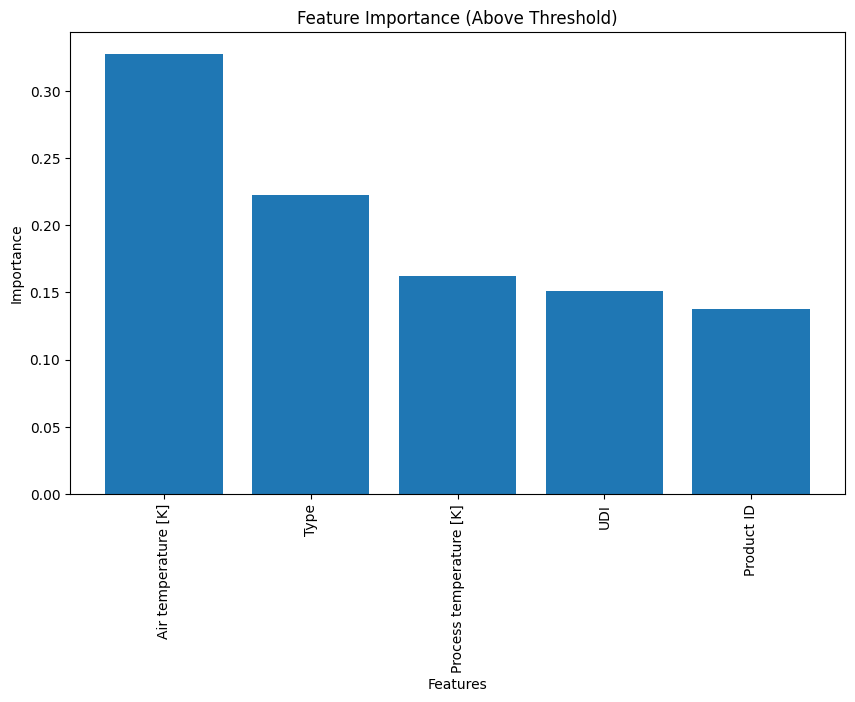

In [10]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt



# Instantiate the Random Forest classifier
rf = RandomForestClassifier()

# Fit the model
rf.fit(X, y)

# Get the feature importances
importances = rf.feature_importances_

# Sort the feature importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]

# Get the feature names
feature_names = dataset1.columns[sorted_indices]

# Set the threshold for feature selection
threshold = 0.005

# Get the indices of features with importance score above the threshold
selected_feature_indices = np.where(sorted_importances >= threshold)[0]

# Get the selected feature names
selected_feature_names = feature_names[selected_feature_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_feature_indices)), sorted_importances[selected_feature_indices])
plt.xticks(range(len(selected_feature_indices)), selected_feature_names, rotation='vertical')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance (Above Threshold)')
plt.show()


## PCA

In [11]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(dataset[['Air temperature [K]', 'Process temperature [K]','Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']])
#X_pca = pca.fit_transform(dataset)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)
X_pca['Machine failure'] = dataset['Machine failure']
X_pca.head(10)

PC1         PC2       PC3       PC4       PC5  Machine failure
0   12.061808 -107.954930  3.338553  2.336402 -0.033861                0
1 -130.938869 -104.939858 -0.117346  2.131336 -0.018299                0
2  -41.195999 -102.951794  7.355197  2.409808 -0.109858                0
3 -105.637391 -100.939724 -5.691865  2.159380 -0.108173                0
4 -130.631921  -98.937020 -6.407013  2.089903 -0.028278                0
5 -113.744294  -96.939923 -3.682666  2.254863 -0.047126                0
6   19.074290  -93.955564  3.285770  2.345642 -0.033877                0
7  -11.781848  -91.950980 -0.418170  2.311167 -0.040267                0
8  128.616880  -89.961861 -5.193517  2.099188 -0.080067                0
9  202.558874  -86.969987 -2.190680  1.807252  0.054244                0

# Chi2

In [12]:
# Feature Selection using chi2, statistical univariate.
from sklearn.feature_selection import SelectKBest, chi2

best_features = SelectKBest(score_func=chi2,k='all')

fit = best_features.fit(X,y)

df_scores=pd.DataFrame(fit.scores_)
df_col=pd.DataFrame(dataset1.columns)

feature_score=pd.concat([df_col,df_scores],axis=1)
feature_score.columns=['feature','score']
feature_score.sort_values(by=['score'],ascending=True,inplace=True)

fig = go.Figure(go.Bar(
            x=feature_score['score'][0:21],
            y=feature_score['feature'][0:21],
            orientation='h'))

fig.update_layout(title="Top 20 Features",
                  height=1200,
                  showlegend=False,
                 )

fig.show()


C:\Users\vthir\AppData\Local\Temp\ipykernel_23732\2608632355.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  x=feature_score['score'][0:21],
C:\Users\vthir\AppData\Local\Temp\ipykernel_23732\2608632355.py:17: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y=feature_score['feature'][0:21],


# Decision Tree

In [13]:
dt_classifier = DecisionTreeClassifier(max_depth=5)
_ = dt_classifier.fit(X_train, y_train)

In [14]:
dt_predictions_train = dt_classifier.predict(X_train)
print("Decision Tree Classification Results on Train Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_train, dt_predictions_train, output_dict = True))

Decision Tree Classification Results on Train Set:
Classification Report


0           1  accuracy    macro avg  weighted avg
precision     0.980038    0.896296  0.978625     0.938167      0.977128
recall        0.998187    0.435252  0.978625     0.716719      0.978625
f1-score      0.989029    0.585956  0.978625     0.787493      0.975023
support    7722.000000  278.000000  0.978625  8000.000000   8000.000000

Confusion Matrix
Confusion Matrix


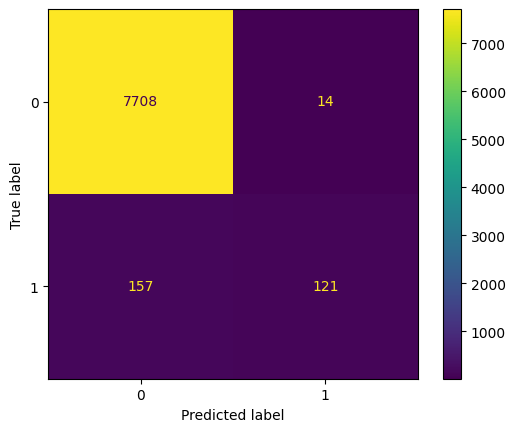

In [15]:
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, dt_predictions_train))

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, dt_predictions_train))
cm = confusion_matrix(y_train, dt_predictions_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_classifier.classes_)
disp.plot()
plt.show()
##7708 predicted perfectly to 0, 121 predicted perfectly to 1. 14 misclassified to 1. 157 misclassified to 0.

In [16]:
dt_predictions_test = dt_classifier.predict(X_test)
print("Decision Tree Classification Results on Test Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_test, dt_predictions_test, output_dict = True))

Decision Tree Classification Results on Test Set:
Classification Report


0          1  accuracy    macro avg  weighted avg
precision     0.982688   0.750000    0.9785     0.866344      0.975591
recall        0.995358   0.442623    0.9785     0.718991      0.978500
f1-score      0.988983   0.556701    0.9785     0.772842      0.975798
support    1939.000000  61.000000    0.9785  2000.000000   2000.000000

Confusion Matrix


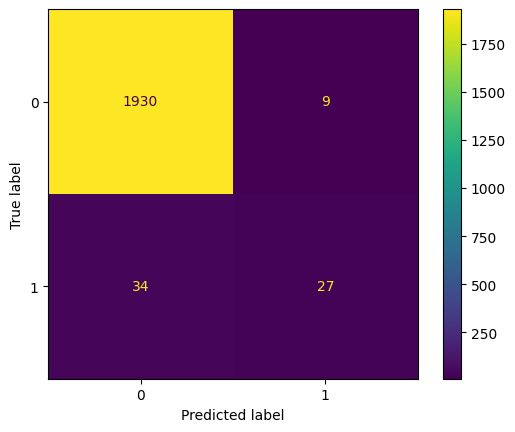

In [17]:

print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, dt_predictions_test))
cm = confusion_matrix(y_test, dt_predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_classifier.classes_)
disp.plot()
plt.show()

# 1930 Class 0 and 27 Class 1 correctly predicted.
# All predicted perfectly

In [18]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.tree import plot_tree

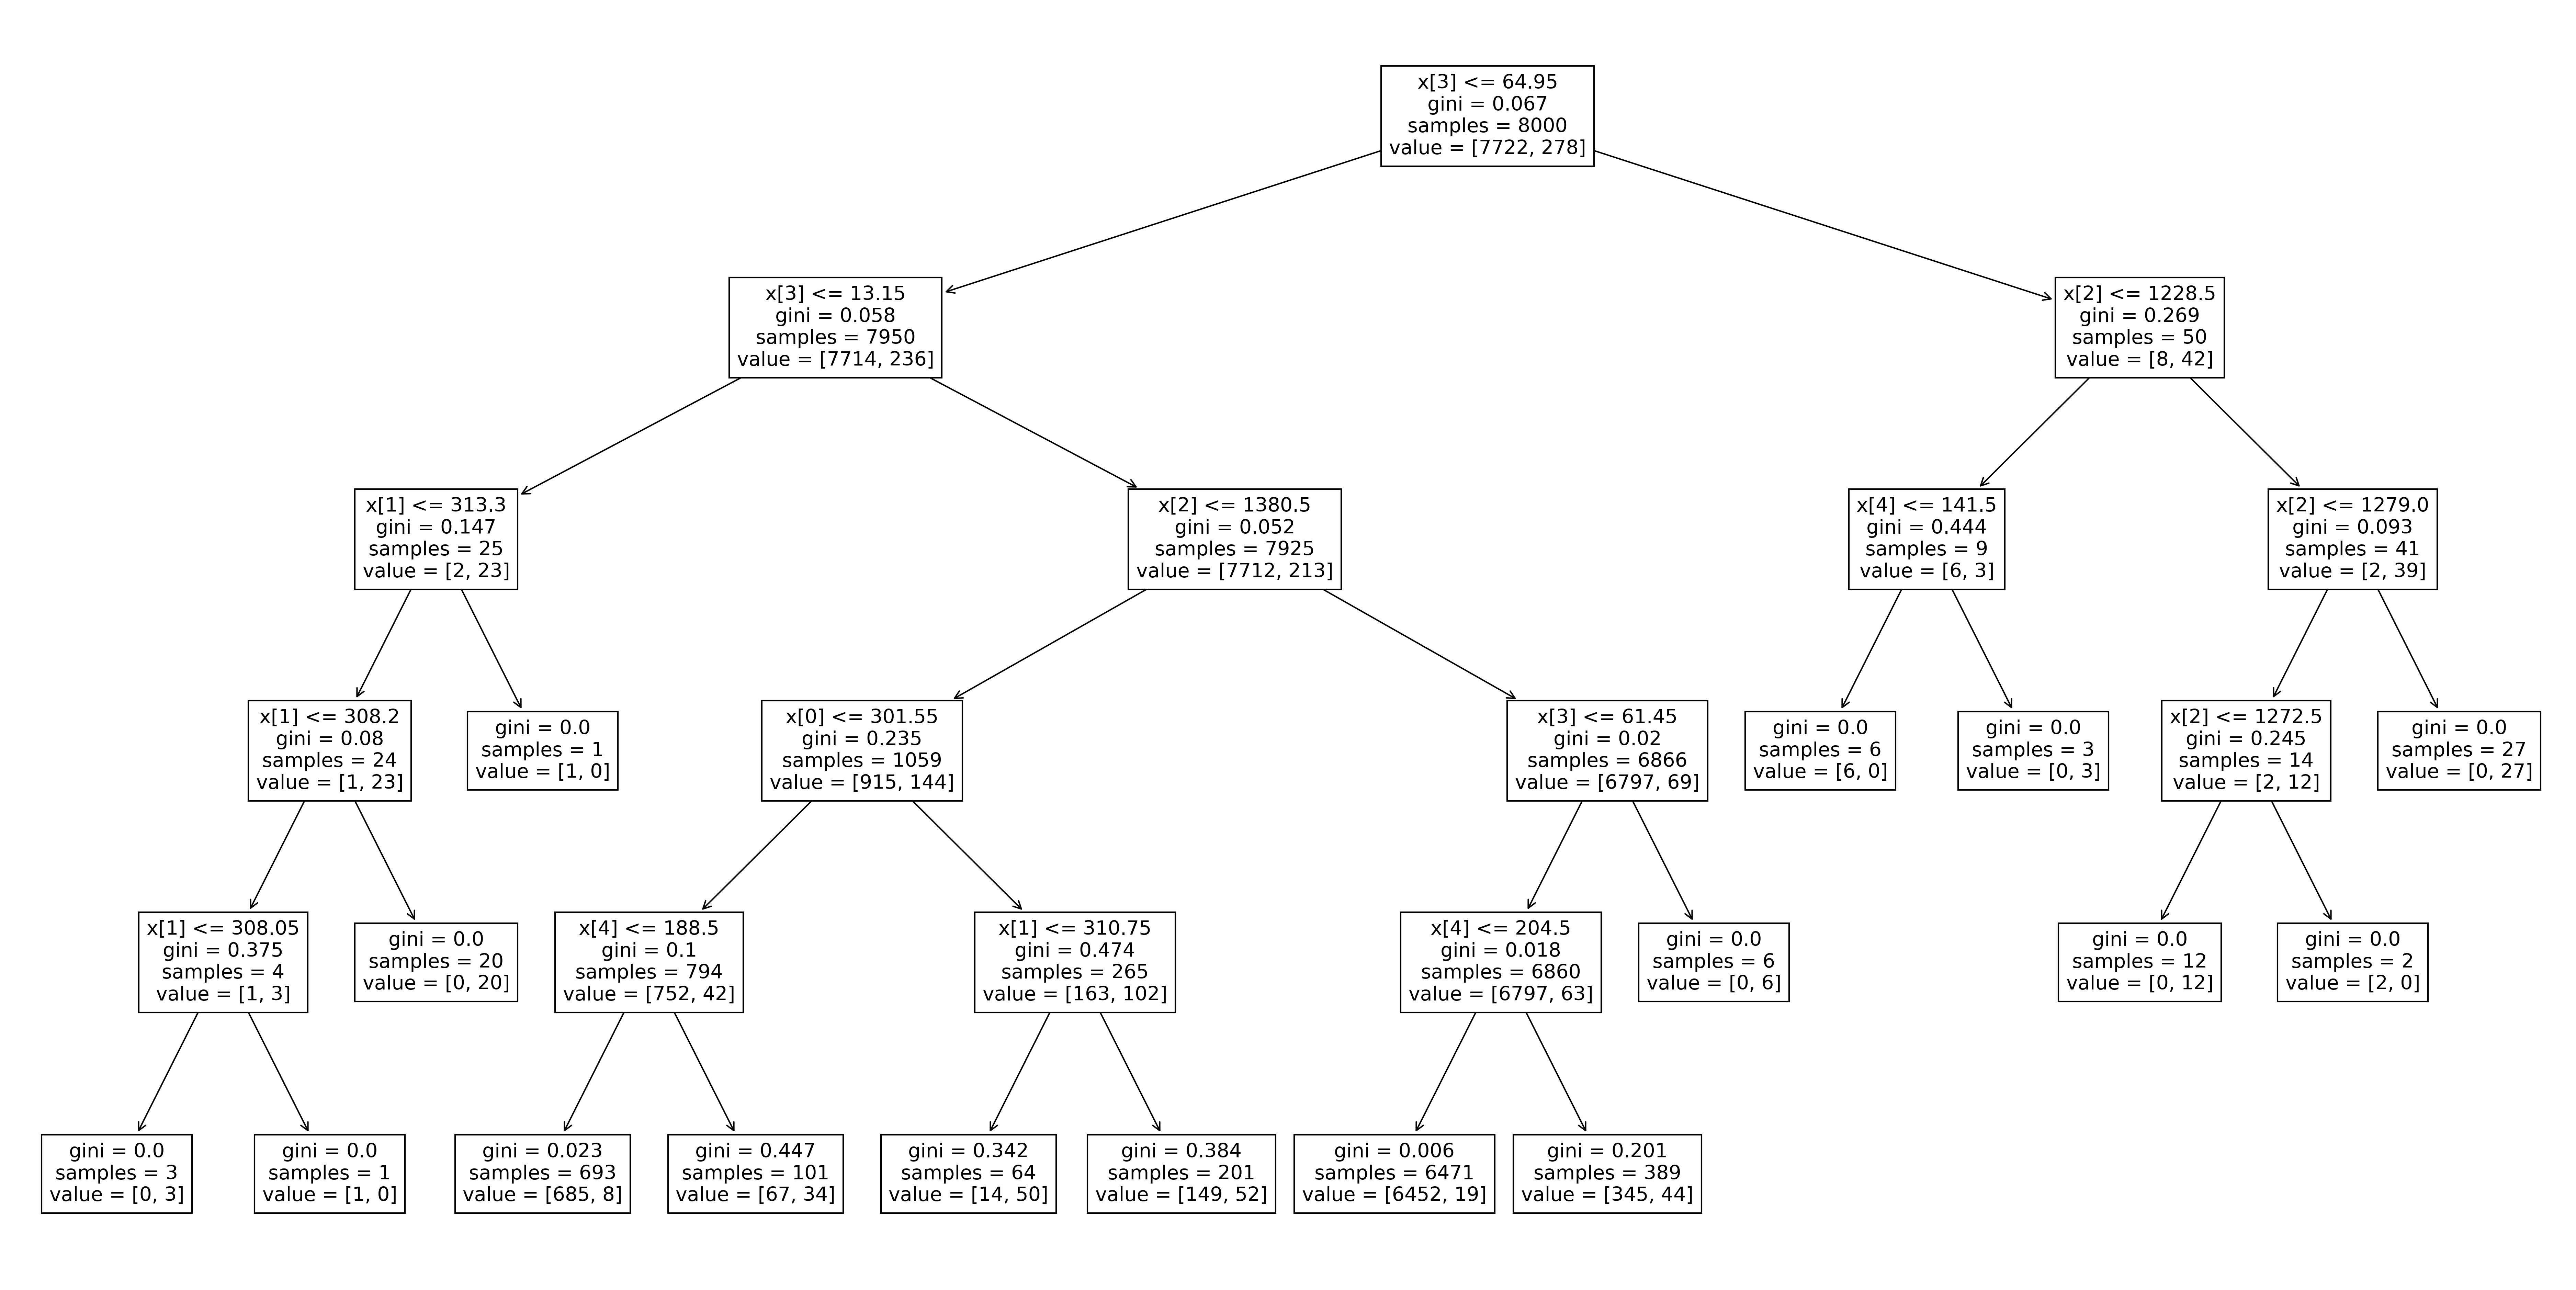

In [19]:
# Fit the model to the training data
dt_classifier.fit(X_train, y_train)

# Visualize the decision tree with increased text size and width
plt.figure(figsize=(32, 16), dpi=300)  # Increase the width by modifying the figsize parameter
plot_tree(dt_classifier)

# Save the plot as a high-resolution PNG image
plt.savefig("decision_tree_high_res.png", dpi=300)

# Show the plot
plt.show()


Training Set Size: 800
Training Accuracy: 0.998 ± 0.0009999999999999788
Validation Accuracy: 0.9674000000000001 ± 0.003555277766926243

Training Set Size: 1600
Training Accuracy: 0.9949999999999999 ± 1.1102230246251565e-16
Validation Accuracy: 0.9511 ± 0.027579702681501103

Training Set Size: 2400
Training Accuracy: 0.99025 ± 0.003958114029012609
Validation Accuracy: 0.9507999999999999 ± 0.02662254683534242

Training Set Size: 3200
Training Accuracy: 0.9878125000000001 ± 0.0034573291714848253
Validation Accuracy: 0.9722 ± 0.005626721958654086

Training Set Size: 4000
Training Accuracy: 0.9844999999999999 ± 0.005648008498577176
Validation Accuracy: 0.9507999999999999 ± 0.045669026703007376

Training Set Size: 4800
Training Accuracy: 0.9801249999999999 ± 0.002570532802531208
Validation Accuracy: 0.8876000000000002 ± 0.17281909616706134

Training Set Size: 5600
Training Accuracy: 0.9804999999999999 ± 0.0011539638872431167
Validation Accuracy: 0.8886 ± 0.17332120470386767

Training Set Siz

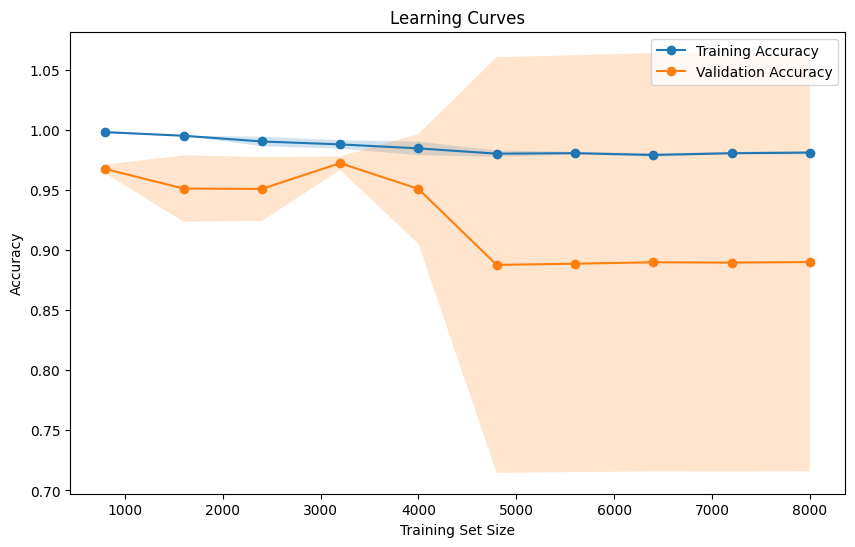

In [20]:

# Compute the learning curves
train_sizes, train_scores, val_scores = learning_curve(
    dt_classifier, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
for i, train_size in enumerate(train_sizes):
    print(f'Training Set Size: {train_size}')
    print(f'Training Accuracy: {train_scores_mean[i]} ± {train_scores_std[i]}')
    print(f'Validation Accuracy: {val_scores_mean[i]} ± {val_scores_std[i]}\n')

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [21]:
print(dataset.columns)

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure'],
      dtype='object')


## Random Forests

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=50)
_ = rf_classifier.fit(X_train, y_train)

In [23]:
rf_predictions_train = rf_classifier.predict(X_train)
print("Random Forest Classification Results on Train Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_train, rf_predictions_train, output_dict = True))

Random Forest Classification Results on Train Set:
Classification Report


0           1  accuracy    macro avg  weighted avg
precision     0.999871    1.000000  0.999875     0.999935      0.999875
recall        1.000000    0.996403  0.999875     0.998201      0.999875
f1-score      0.999935    0.998198  0.999875     0.999067      0.999875
support    7722.000000  278.000000  0.999875  8000.000000   8000.000000

Confusion Matrix
Confusion Matrix


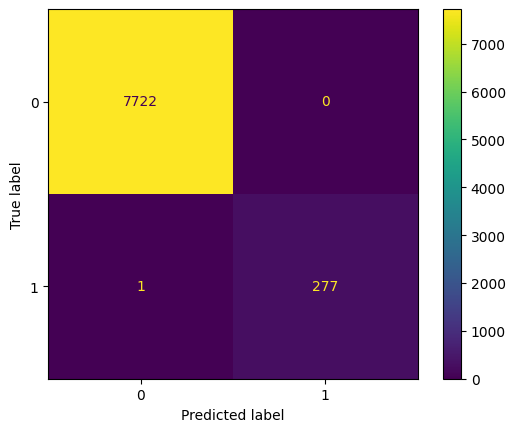

In [24]:
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, rf_predictions_train))

# Training set 8k
# 7722 Class 0 and 278 Class 1
# Class 0: All predicted perfectly
# Class 1: 277 predicted correctly, 1 predicted wrongly
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, rf_predictions_train))
cm = confusion_matrix(y_train, rf_predictions_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

In [25]:
rf_predictions_test = rf_classifier.predict(X_test)
print("Random Forest Classification Results on Test Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_test, rf_predictions_test, output_dict = True))

Random Forest Classification Results on Test Set:
Classification Report


0          1  accuracy    macro avg  weighted avg
precision     0.987724   0.822222     0.984     0.904973      0.982676
recall        0.995874   0.606557     0.984     0.801216      0.984000
f1-score      0.991782   0.698113     0.984     0.844948      0.982825
support    1939.000000  61.000000     0.984  2000.000000   2000.000000

Confusion Matrix
Confusion Matrix


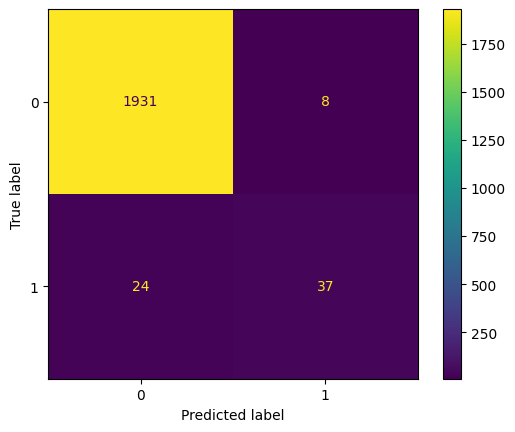

In [26]:
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, rf_predictions_test))

# Training set 8k
# 7722 Class 0 and 278 Class 1
# Class 0: All predicted perfectly
# Class 1: 277 predicted correctly, 1 predicted wrongly


# Training set 8k
# 7722 Class 0 and 278 Class 1
# Class 0: All predicted perfectly
# Class 1: 277 predicted correctly, 1 predicted wrongly
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, rf_predictions_test))
cm = confusion_matrix(y_test, rf_predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_classifier.classes_)
disp.plot()
plt.show()

Training Set Size: 800
Training Accuracy: 1.0 ± 0.0
Validation Accuracy: 0.9674000000000001 ± 0.004872371086031929

Training Set Size: 1600
Training Accuracy: 0.99975 ± 0.0004999999999999894
Validation Accuracy: 0.9727 ± 0.004456455991031443

Training Set Size: 2400
Training Accuracy: 0.9999166666666668 ± 0.0001666666666666483
Validation Accuracy: 0.9662 ± 0.014548539445593834

Training Set Size: 3200
Training Accuracy: 0.999875 ± 0.00015309310892397258
Validation Accuracy: 0.9662000000000001 ± 0.014569145479402692

Training Set Size: 4000
Training Accuracy: 0.9999500000000001 ± 9.999999999998899e-05
Validation Accuracy: 0.9734999999999999 ± 0.003728270376461462

Training Set Size: 4800
Training Accuracy: 0.9998333333333334 ± 8.333333333334635e-05
Validation Accuracy: 0.8887 ± 0.17437820964788

Training Set Size: 5600
Training Accuracy: 0.9998928571428571 ± 8.748177652799209e-05
Validation Accuracy: 0.8884000000000001 ± 0.1739831601046492

Training Set Size: 6400
Training Accuracy: 0.9

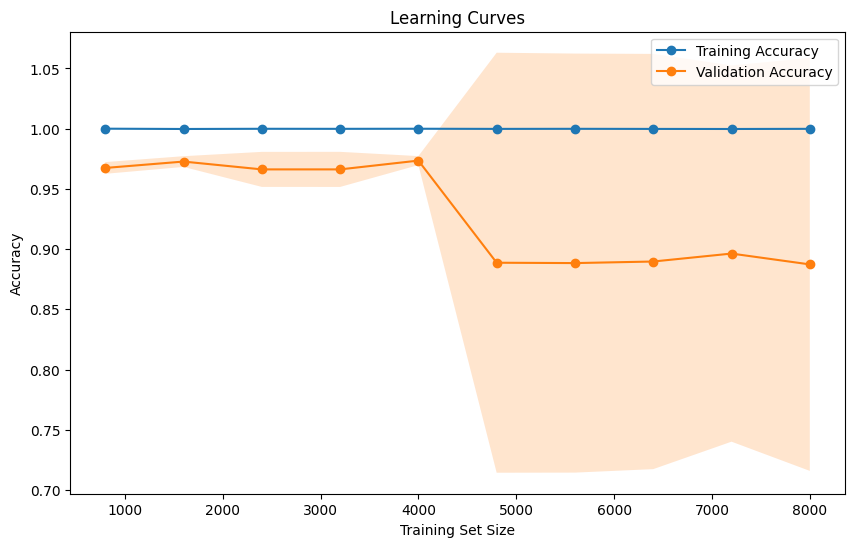

In [27]:

# Compute the learning curves
train_sizes, train_scores, val_scores = learning_curve(
    rf_classifier, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
for i, train_size in enumerate(train_sizes):
    print(f'Training Set Size: {train_size}')
    print(f'Training Accuracy: {train_scores_mean[i]} ± {train_scores_std[i]}')
    print(f'Validation Accuracy: {val_scores_mean[i]} ± {val_scores_std[i]}\n')

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


# SVM

In [28]:
svm_classifier = SVC(C=1.0, kernel='rbf', gamma='scale')
_ = svm_classifier.fit(X_train, y_train)

In [29]:
svm_predictions_train = svm_classifier.predict(X_train)
print("SVM Results on Train Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_train, svm_predictions_train, output_dict = True))

SVM Results on Train Set:
Classification Report


0           1  accuracy    macro avg  weighted avg
precision     0.966337    1.000000  0.966375     0.983169      0.967507
recall        1.000000    0.032374  0.966375     0.516187      0.966375
f1-score      0.982880    0.062718  0.966375     0.522799      0.950905
support    7722.000000  278.000000  0.966375  8000.000000   8000.000000

Confusion Matrix
Confusion Matrix


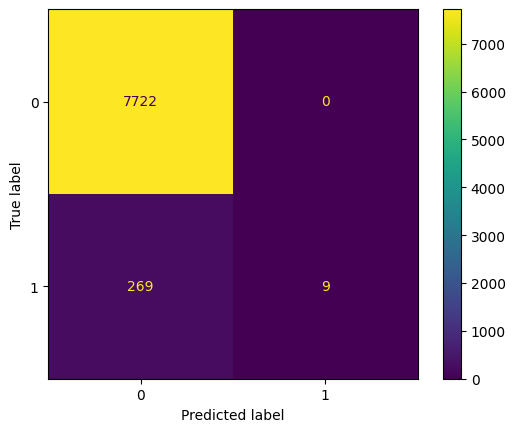

In [30]:
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, svm_predictions_train))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, dt_predictions_train))
cm = confusion_matrix(y_train, svm_predictions_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_classifier.classes_)
disp.plot()
plt.show()
# Training set 8k
# 7722 Class 0 and 278 Class 1
# Class 0: All predicted perfectly
# Class 1: 269 predicted correctly, 9 predicted wrongly

In [31]:
svm_predictions_test = svm_classifier.predict(X_test)
print("SVM Results on Test Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_test, svm_predictions_test, output_dict = True))

SVM Results on Test Set:
Classification Report


0          1  accuracy    macro avg  weighted avg
precision     0.970470   1.000000    0.9705     0.985235      0.971371
recall        1.000000   0.032787    0.9705     0.516393      0.970500
f1-score      0.985014   0.063492    0.9705     0.524253      0.956908
support    1939.000000  61.000000    0.9705  2000.000000   2000.000000

Confusion Matrix


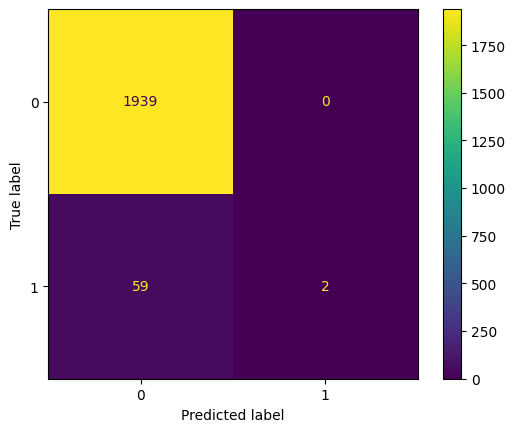

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, svm_predictions_test))
cm = confusion_matrix(y_test, svm_predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot()
plt.show()
# Test set 2k
# 1939 Class 0 and 61 Class 1
# Class 0: All predicted correctly
# Class 1: 2 predicted correctly, 59 predicted wrong

Training Set Size: 800
Training Accuracy: 0.98225 ± 0.006999999999999984
Validation Accuracy: 0.9661000000000002 ± 0.00020000000000002237

Training Set Size: 1600
Training Accuracy: 0.976625 ± 0.005750000000000011
Validation Accuracy: 0.9662000000000001 ± 0.0002449489742783452

Training Set Size: 2400
Training Accuracy: 0.9716666666666667 ± 0.007221688014431099
Validation Accuracy: 0.9669000000000001 ± 0.0007348469228349511

Training Set Size: 3200
Training Accuracy: 0.9655625000000001 ± 0.014271912976192081
Validation Accuracy: 0.9667 ± 0.0009273618495495879

Training Set Size: 4000
Training Accuracy: 0.9664999999999999 ± 0.010358571330062839
Validation Accuracy: 0.967 ± 0.0008944271909999291

Training Set Size: 4800
Training Accuracy: 0.9586666666666666 ± 0.0016061946056163613
Validation Accuracy: 0.9671000000000001 ± 0.000734846922834957

Training Set Size: 5600
Training Accuracy: 0.9617857142857142 ± 0.0024301465480291253
Validation Accuracy: 0.9669000000000001 ± 0.0007348469228349

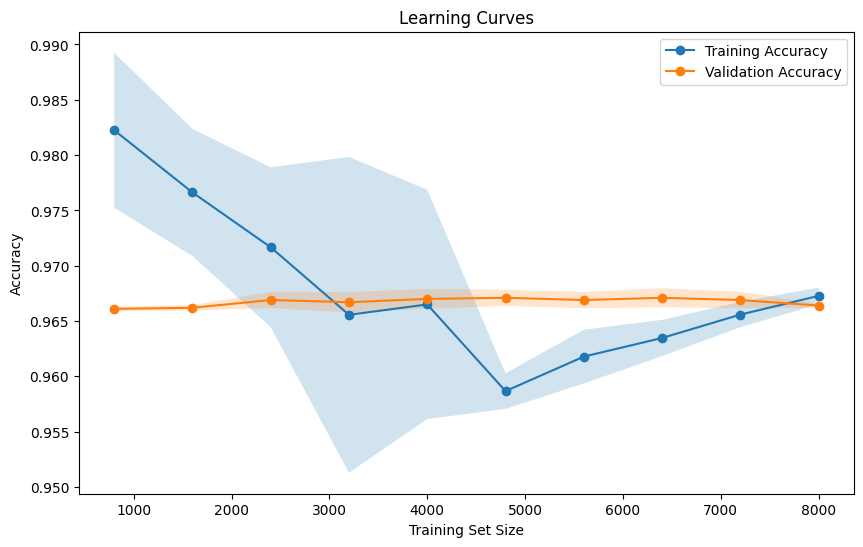

In [33]:

# Compute the learning curves
train_sizes, train_scores, val_scores = learning_curve(
    svm_classifier, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
for i, train_size in enumerate(train_sizes):
    print(f'Training Set Size: {train_size}')
    print(f'Training Accuracy: {train_scores_mean[i]} ± {train_scores_std[i]}')
    print(f'Validation Accuracy: {val_scores_mean[i]} ± {val_scores_std[i]}\n')

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


# knn

In [34]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)

_ = knn_classifier.fit(X_train, y_train)

In [35]:
knn_predictions_train = knn_classifier.predict(X_train)
print("KNN Results on Train Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_train, knn_predictions_train, output_dict = True))

KNN Results on Train Set:
Classification Report


0           1  accuracy    macro avg  weighted avg
precision     0.975434    0.815534  0.973375     0.895484      0.969877
recall        0.997539    0.302158  0.973375     0.649849      0.973375
f1-score      0.986363    0.440945  0.973375     0.713654      0.967409
support    7722.000000  278.000000  0.973375  8000.000000   8000.000000

Confusion Matrix


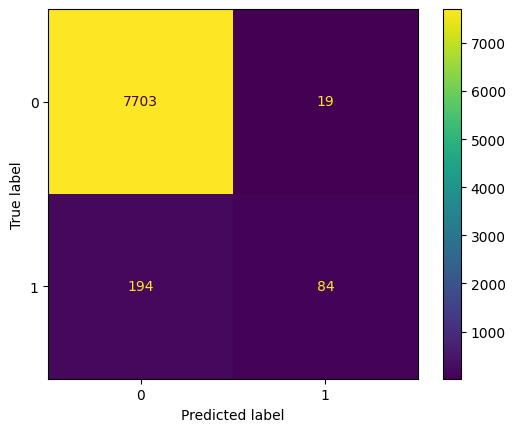

In [36]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_train, knn_predictions_train))
cm = confusion_matrix(y_train, knn_predictions_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier.classes_)
disp.plot()
plt.show()
# Training set 8k
# 7708 Class 0 and 278 Class 1
# Class 0: 7703 predicted correctly, 19 predicted incorrectly
# Class 1: 194 predicted correctly, 84 predicted wrongly

In [37]:
knn_predictions_test = knn_classifier.predict(X_test)
print("KNN Results on Test Set:")
print('Classification Report')
pd.DataFrame(classification_report(y_test, knn_predictions_test, output_dict = True))

KNN Results on Test Set:
Classification Report


0          1  accuracy    macro avg  weighted avg
precision     0.973313   0.571429    0.9705     0.772371      0.961056
recall        0.996906   0.131148    0.9705     0.564027      0.970500
f1-score      0.984968   0.213333    0.9705     0.599151      0.961433
support    1939.000000  61.000000    0.9705  2000.000000   2000.000000

Confusion Matrix
Confusion Matrix


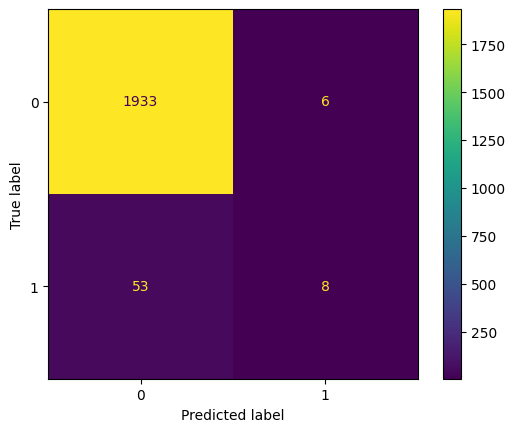

In [38]:
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, knn_predictions_test))


# Training set 8k
# 7722 Class 0 and 278 Class 1
# Class 0: All predicted perfectly
# Class 1: 277 predicted correctly, 1 predicted wrongly
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
pd.DataFrame(confusion_matrix(y_test, knn_predictions_test))
cm = confusion_matrix(y_test, knn_predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn_classifier.classes_)
disp.plot()
plt.show()
# Training set 8k
# 7708 Class 0 and 278 Class 1
# Class 0: 7703 predicted correctly, 19 predicted incorrectly
# Class 1: 194 predicted correctly, 84 predicted wrongly
# Test set 2k
# 1939 Class 0 and 61 Class 1
# Class 0: 1933 predicted correctly, 6 predicted wrong
# Class 1: 8 predicted correctly, 53 predicted wrong

Training Set Size: 800
Training Accuracy: 0.9852500000000001 ± 0.005499999999999972
Validation Accuracy: 0.9676 ± 0.0013928388277184196

Training Set Size: 1600
Training Accuracy: 0.9827499999999999 ± 0.0042499999999999994
Validation Accuracy: 0.9692000000000001 ± 0.001989974874213237

Training Set Size: 2400
Training Accuracy: 0.9770833333333334 ± 0.0067905162624878135
Validation Accuracy: 0.9688000000000001 ± 0.002014944167960987

Training Set Size: 3200
Training Accuracy: 0.97325 ± 0.010609547586961492
Validation Accuracy: 0.9658 ± 0.0035014282800023364

Training Set Size: 4000
Training Accuracy: 0.97345 ± 0.008845055115712963
Validation Accuracy: 0.9672000000000001 ± 0.0030099833886584907

Training Set Size: 4800
Training Accuracy: 0.9677083333333334 ± 0.0014965237496723175
Validation Accuracy: 0.9667999999999999 ± 0.0026191601707417503

Training Set Size: 5600
Training Accuracy: 0.9698571428571429 ± 0.0018605737539473042
Validation Accuracy: 0.9676 ± 0.0026532998322843166

Trainin

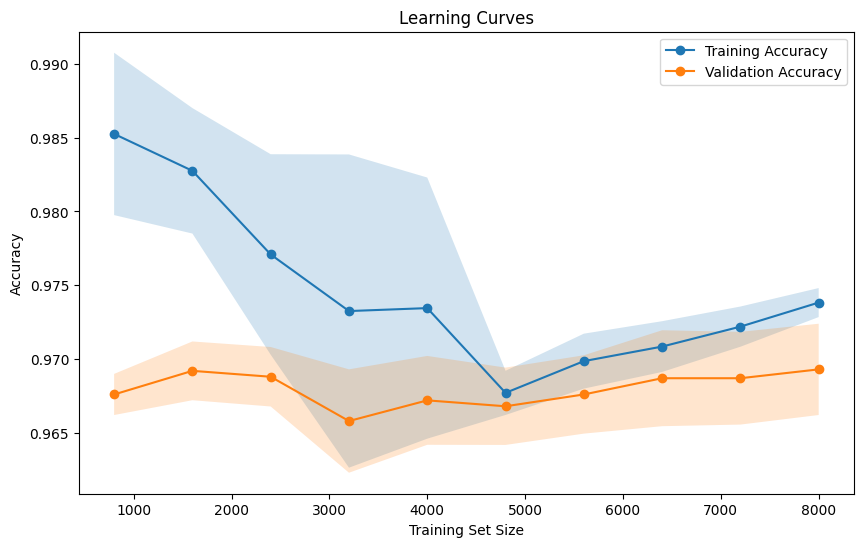

In [39]:

# Compute the learning curves
train_sizes, train_scores, val_scores = learning_curve(
    knn_classifier, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate the mean and standard deviation of the training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)
for i, train_size in enumerate(train_sizes):
    print(f'Training Set Size: {train_size}')
    print(f'Training Accuracy: {train_scores_mean[i]} ± {train_scores_std[i]}')
    print(f'Validation Accuracy: {val_scores_mean[i]} ± {val_scores_std[i]}\n')

# Plot the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation Accuracy')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2)
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2)
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curves')
plt.legend()
plt.show()


Result comparison

In [41]:
import plotly.graph_objects as go
from sklearn.metrics import classification_report

def extract_metrics(classification_report_dict):
    metrics = {}
    metrics['precision'] = classification_report_dict['1']['precision']
    metrics['recall'] = classification_report_dict['1']['recall']
    metrics['accuracy'] = classification_report_dict['accuracy']
    metrics['f1_score'] = classification_report_dict['1']['f1-score']
    return metrics

# Assuming dt_predictions_test, rf_predictions_test, etc. are already defined

dt_metrics_train = extract_metrics(classification_report(y_train, dt_predictions_train, output_dict=True))
rf_metrics_train = extract_metrics(classification_report(y_train, rf_predictions_train, output_dict=True))
svm_metrics_train = extract_metrics(classification_report(y_train, svm_predictions_train, output_dict=True))
knn_metrics_train = extract_metrics(classification_report(y_train, knn_predictions_train, output_dict=True))

dt_metrics_test = extract_metrics(classification_report(y_test, dt_predictions_test, output_dict=True))
rf_metrics_test = extract_metrics(classification_report(y_test, rf_predictions_test, output_dict=True))
svm_metrics_test = extract_metrics(classification_report(y_test, svm_predictions_test, output_dict=True))
knn_metrics_test = extract_metrics(classification_report(y_test, knn_predictions_test, output_dict=True))

# Plotting the metrics
def plot_metric(metric_name):
    classifiers = ['Decision Tree Train',
                   'Decision Tree Test',
                   'Random Forest Train',
                   'Random Forest Test',
                   'SVM Train', 
                   'SVM Test',
                   'KNN Train',
                   'KNN Test' ]
    metric_values = [dt_metrics_train[metric_name], 
    dt_metrics_test[metric_name],
    rf_metrics_train[metric_name], 
    rf_metrics_test[metric_name],   
    svm_metrics_train[metric_name],  
            svm_metrics_test[metric_name],  
  knn_metrics_train[metric_name],
                               knn_metrics_test[metric_name]]

    
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=classifiers, y=metric_values,
                             mode='lines+markers',
                             name=metric_name))

    fig.update_layout(title=f'{metric_name.capitalize()} Comparison',
                      xaxis_title='Classifiers',
                      yaxis_title=f'{metric_name.capitalize()} Score',
                      legend_title='Classifiers')

    fig.show()

# Plotting Precision, Recall, Accuracy, and F1 Score separately
plot_metric('precision')
plot_metric('recall')
plot_metric('accuracy')
plot_metric('f1_score')


C:\Users\vthir\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\vthir\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Selected Features:
Air temperature [K]
Process temperature [K]
TWF
HDF
PWF
OSF


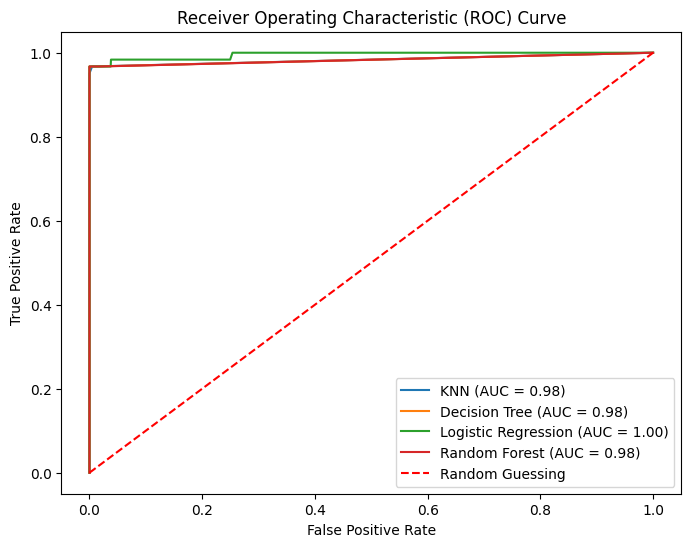

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import itertools 

from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv("ai4i2020.csv")

# Perform label encoding on the "Type" column
label_encoder = LabelEncoder()
df["Type"] = label_encoder.fit_transform(df["Type"])
df = df.drop(["Product ID", "UDI"], axis=1)
# Perform label encoding on the "Type" column
label_encoder = LabelEncoder()
df["Type"] = label_encoder.fit_transform(df["Type"])

# Separate the features (X) and the target variable (y)
X = df.drop(["Machine failure"], axis=1)
y = df["Machine failure"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def calculate_auc(model, X, y):
    y_pred_proba = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, y_pred_proba)


# Perform feature selection using Best Subset method
best_auc = 0
best_features = []
all_features = X.columns.tolist()

for k in range(1, len(all_features) + 1):
    for subset in itertools.combinations(all_features, k):
        selected_features = list(subset)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]

        # Train a logistic regression model
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_subset, y_train)

        # Calculate the AUC score on the test set
        auc = calculate_auc(model, X_test_subset, y_test)

        if auc > best_auc:
            best_auc = auc
            best_features = selected_features

# Print the selected features
print("Selected Features:")
for feature in best_features:
    print(feature)

# Train and evaluate different models using the selected features
models = {
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier()
}

# Plot ROC curves for each model
plt.figure(figsize=(8, 6))
for model_name, model in models.items():
    # Train the model on the selected features
    model.fit(X_train[best_features], y_train)

    # Calculate the predicted probabilities for the positive class
    y_pred_proba = model.predict_proba(X_test[best_features])[:, 1]

    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Calculate the AUC score
    auc = roc_auc_score(y_test, y_pred_proba)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.2f})")

# Plot the random guessing ROC curve (dashed line)
plt.plot([0, 1], [0, 1], "r--", label="Random Guessing")

# Set the plot title and labels
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Set the legend
plt.legend(loc="lower right")

# Show the plot
plt.show()
